# CSU EDA v0.3
- 2022-01-01 to present (starts on a saturday)
- DMA split 3 ways:
    - awareness_markets: Orlando, Jacksonville, Greenville, SC and Birmingham
    - Mobile (DMA)
    - all national DMA
- it's been decided to only use cohort view (KPI by Lead date)
- Media Data (set up by Mike for Geo): Bing, Google, Meta, TikTok, TTD, LinkedIn
    - what to do with linkedIn since it has no geo info???

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [4]:
kpi_raw = pd.read_csv('../data/CSU_KPI_raw_2022-01-01_2025-01-15.csv')
tiktok_raw = pd.read_csv('../data/CSU_data_tiktok_raw_2024-01-15.csv')
meta_raw = pd.read_csv('../data/CSU_data_meta_raw_2024-01-15.csv')
google_raw = pd.read_csv('../data/CSU_data_google_raw_2024-01-15.csv')
bing_raw = pd.read_csv('../data/CSU_data_bing_raw_2024-01-15.csv')
ttd_raw = pd.read_csv('../data/CSU_data_TTD_raw_2024-01-15.csv')
linkedin_raw = pd.read_csv('../data/CSU_data_linkedin_raw_2024-01-15.csv')

rev_map_raw = pd.read_excel('../data/Average revenue per application per week.xlsx')

## KPI stuff

In [5]:
rev_map = rev_map_raw[[2023]].copy()
rev_map = rev_map[~rev_map[2023].isna()]
# rev_map

In [6]:
# list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']

df_kpi_full = kpi_raw.copy()
df_kpi_full['leaddate'] = pd.to_datetime(df_kpi_full['leaddate']).dt.normalize()
df_kpi_full['appdate'] = pd.to_datetime(df_kpi_full['appdate']).dt.normalize()
df_kpi_full['enrolldate'] = pd.to_datetime(df_kpi_full['enrolldate']).dt.normalize()
df_kpi_full['dma'] = None
df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('MOBILE-PENSACOLA', na=False), 'dma'] = 'mobile'
df_kpi_full.loc[df_kpi_full['dma'].isna(), 'dma'] = 'national'
df_kpi_full = df_kpi_full.loc[df_kpi_full['leaddate'] < pd.Timestamp.today()].drop(['dmaname'], axis=1) 
df_kpi_full['channel'] = None
# df_kpi_full.loc[df_kpi_full['dw_vendor'] == 'ArcherOrg', 'channel'] = 'Organic'
# df_kpi_full.loc[df_kpi_full['dw_channel'].str.contains('Referral'), 'channel'] = 'Referral'
df_kpi_full.loc[df_kpi_full['dw_channel'].str.contains('PPL'), 'channel'] = 'PPL'
df_kpi_full.loc[df_kpi_full['channel'].isna(), 'channel'] = 'ALL(No PPL,Referral)' #NO PPL BUT Everything else
df_kpi_full = df_kpi_full.loc[df_kpi_full.leaddate < '2025-01-10'] ##keeping with saturday-friday

### Making cohort KPI data frame where all KPI are by the lead date (drop organic being separated, roll into ALL with referral)
df_kpi_cohort = df_kpi_full.loc[df_kpi_full.dma != 'mobile'].copy()
df_kpi_cohort = df_kpi_cohort.groupby(['leaddate', 'dma', 'channel'])[['n_lead', 'n_app', 'n_enroll']].agg('sum')
df_kpi_cohort = df_kpi_cohort.unstack(['dma', 'channel']).reorder_levels([1,2, 0], axis=1).sort_index(axis=1).fillna(0)

df_kpi_cohort_weekly = df_kpi_cohort.resample('W-Sat').sum()
df_kpi_cohort_weekly_aware = df_kpi_cohort.resample('W-Sat').sum()[('awareness', 'ALL(No PPL,Referral)')]
df_kpi_cohort_weekly_national = df_kpi_cohort.resample('W-Sat').sum()[('national', 'ALL(No PPL,Referral)')]

# df_kpi_cohort_monthly = df_kpi_cohort.resample('MS').sum()

C:\Users\ktaljan\AppData\Local\Temp\ipykernel_11524\206930320.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'


In [7]:
### Need to calculate the lead to app ratio and multiply revenue by that?

l2a_aware_conv = df_kpi_cohort_weekly_aware['n_app']/df_kpi_cohort_weekly_aware['n_lead']
l2a_national_conv = df_kpi_cohort_weekly_national['n_app']/df_kpi_cohort_weekly_national['n_lead']

In [8]:
### convolution
kernel = rev_map.values.flatten() #len = 52
x_val_a = np.array(df_kpi_cohort_weekly_aware['n_app'].values) #len = 159
revenue_app_aware = np.convolve(x_val_a, kernel, mode='same')

df_kpi_cohort_weekly_aware['revenue_app'] = revenue_app_aware
df_kpi_cohort_weekly_aware['revenue_lead'] = revenue_app_aware * l2a_aware_conv

kernel = rev_map.values.flatten() #len = 52
x_val_n = np.array(df_kpi_cohort_weekly_national['n_app'].values) #len = 159
revenue_app_national = np.convolve(x_val_n, kernel, mode='same')

df_kpi_cohort_weekly_national['revenue_app'] = revenue_app_national
df_kpi_cohort_weekly_national['revenue_lead'] = revenue_app_national * l2a_national_conv

In [9]:
revenue_app_national

array([120994.853428, 127718.829022, 134514.607542, 140319.150851,
       145529.715475, 150151.16708 , 154318.696057, 158904.356564,
       164608.145776, 171345.278087, 179040.038648, 186613.411209,
       193421.09558 , 199783.329401, 204557.724202, 208367.479363,
       211961.688608, 215505.762967, 220266.150955, 226702.946031,
       233168.680112, 238935.268249, 245218.465371, 249981.912409,
       253444.607569, 257050.668546, 260088.160385, 263116.589824,
       262184.123085, 261445.909361, 261114.628176, 261965.429931,
       264759.103308, 268744.642288, 274003.56605 , 279323.498355,
       284251.950278, 287156.335998, 288646.798355, 291163.868471,
       293635.700601, 297207.737999, 302623.798132, 308312.717727,
       313185.021   , 317792.122868, 320709.371131, 322881.223622,
       324938.695822, 328136.032472, 332475.819126, 337191.047777,
       343161.727713, 348484.734038, 352568.629104, 355906.088934,
       357978.19866 , 359048.369152, 360849.630598, 362992.070

In [10]:
revenue_app_aware

array([ 4842.475188,  5173.490528,  5376.602256,  5589.572492,
        5806.928006,  5928.732046,  6098.987104,  6253.88211 ,
        6431.717427,  6645.504026,  6923.974523,  7100.947354,
        7351.53557 ,  7522.968719,  7670.09396 ,  7850.504604,
        7988.448755,  8127.720921,  8252.237427,  8405.309276,
        8521.327064,  8764.191515,  8904.633621,  9020.037767,
        9144.46142 ,  9257.546473,  9416.153371,  9582.073674,
        9568.489984,  9462.117144,  9367.147939,  9231.408704,
        9202.481337,  9384.876086,  9635.109354,  9809.511084,
        9750.821931,  9670.45845 ,  9850.514134,  9820.304077,
        9731.099116,  9787.5897  ,  9979.683262, 10209.41289 ,
       10499.698511, 10514.610241, 10419.821067, 10409.65907 ,
       10226.339467, 10182.550272, 10109.727492, 10282.119041,
       10285.012649, 10504.465396, 10631.513433, 10860.714521,
       11089.677993, 11287.252675, 11607.581576, 11844.473481,
       12031.516507, 12210.483935, 12444.337662, 12561.

## Revenue Stuff

In [11]:
# list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'GREENWOOD-GREENVILLE, MS', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM, AL']
list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM, AL']

df_goo = google_raw.copy()
df_goo['Date'] = pd.to_datetime(df_goo['Date'])
df_goo['Metro area'] = df_goo['Metro area'].str.upper()
df_goo['dma'] = None
df_goo.loc[df_goo['Metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_goo.loc[df_goo['Metro area'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_goo.loc[df_goo['dma'].isna(), 'dma'] = 'national'
df_goo = df_goo.loc[df_goo.dma != 'mobile']
df_goo['channel'] = None
df_goo.loc[df_goo['Brand'] == 'Brand', 'channel'] = 'SearchBrand'
df_goo.loc[df_goo['Campaign name'].str.contains('YouTube'), 'channel'] = 'YouTube'
df_goo.loc[df_goo['Campaign name'].str.contains('Display'), 'channel'] = 'Display'
df_goo.loc[df_goo['channel'].isna(), 'channel'] = 'SearchNonBrand' ###not certain if this is what we can make nonBrand
df_goo = df_goo.rename(columns={'Cost':'spend', 'Date':'date'})
df_goo = df_goo[['date', 'dma', 'channel', 'spend']]

In [12]:
# list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'GREENWOOD-GREENVILLE, MS', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM']
list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM (ANNISTON AND TUSCALOOSA), AL']

df_bing = bing_raw.copy()
df_bing['Date'] = pd.to_datetime(df_bing['Date'])
df_bing['Visitor metro area'] = df_bing['Visitor metro area'].str.upper()
df_bing['dma'] = None
df_bing.loc[df_bing['Visitor metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_bing.loc[df_bing['Visitor metro area'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_bing = df_bing.loc[df_bing.dma != 'mobile']
df_bing.loc[df_bing['dma'].isna(), 'dma'] = 'national'
df_bing['channel'] = None
df_bing.loc[df_bing['Brand'] == 'Brand', 'channel'] = 'SearchBrand'
df_bing.loc[df_bing['Brand'] == 'Non Brand', 'channel'] = 'SearchNonBrand'
df_bing = df_bing.rename(columns={'Cost':'spend', 'Date':'date'})
df_bing = df_bing.groupby(['date', 'dma', 'channel'])['spend'].agg('sum').reset_index()

C:\Users\ktaljan\AppData\Local\Temp\ipykernel_11524\2589500047.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_bing.loc[df_bing['Visitor metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'


In [13]:
# list_awareness = ['GREENVILLE - SPARTANBURG - ASHEVILLE - ANDERSON', 'JACKSONVILLE', 'GREENWOOD - GREENVILLE', 'ORLANDO - DAYTONA BEACH - MELBOURNE', 'BIRMINGHAM']
list_awareness = ['GREENVILLE - SPARTANBURG - ASHEVILLE - ANDERSON', 'JACKSONVILLE', 'ORLANDO - DAYTONA BEACH - MELBOURNE', 'BIRMINGHAM']

df_tiktok = tiktok_raw.copy()
df_tiktok['Date'] = pd.to_datetime(df_tiktok['Date'])
df_tiktok['DMA name'] = df_tiktok['DMA name'].str.upper()
df_tiktok['dma'] = None
df_tiktok.loc[df_tiktok['DMA name'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_tiktok.loc[df_tiktok['DMA name'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_tiktok = df_tiktok.loc[df_tiktok.dma != 'mobile']
df_tiktok.loc[df_tiktok['dma'].isna(), 'dma'] = 'national'
df_tiktok['channel'] = 'TikTok'
df_tiktok = df_tiktok.rename(columns={'Cost':'spend', 'Date':'date'})
df_tiktok = df_tiktok[['date', 'dma', 'channel', 'spend']]

In [14]:
# list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM']
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM']

df_meta = meta_raw.copy()
df_meta['Date'] = pd.to_datetime(df_meta['Date'])
df_meta['DMA'] = df_meta['DMA'].str.upper()
df_meta['dma'] = None
df_meta.loc[df_meta['DMA'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_meta.loc[df_meta['DMA'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_meta = df_meta.loc[df_meta.dma != 'mobile']
df_meta.loc[df_meta['dma'].isna(), 'dma'] = 'national'
df_meta['channel'] = 'Meta'
df_meta = df_meta.rename(columns={'Cost':'spend', 'Date':'date'})
df_meta = df_meta[['date', 'dma', 'channel', 'spend']]

In [15]:
# list_awareness = ['GREENVILLE-SPARTANBURG SC-ASHEVILLE NC-ANDERSON SC', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BEACH-MELBOURNE', 'BIRMINGHAM']
list_awareness = ['GREENVILLE-SPARTANBURG SC-ASHEVILLE NC-ANDERSON SC', 'JACKSONVILLE', 'ORLANDO-DAYTONA BEACH-MELBOURNE', 'BIRMINGHAM']

df_ttd = ttd_raw.copy()
df_ttd['record_date'] = pd.to_datetime(df_ttd['record_date'])
df_ttd['metro'] = df_ttd['metro'].str.upper()
df_ttd['dma'] = None
df_ttd.loc[df_ttd['metro'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_ttd.loc[df_ttd['metro'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_ttd = df_ttd.loc[df_ttd.dma != 'mobile']
df_ttd.loc[df_ttd['dma'].isna(), 'dma'] = 'national'
df_ttd.loc[df_ttd['campaign_name'].str.contains('DOOH'), 'channel'] = 'DOOH'
df_ttd.loc[df_ttd['campaign_name'].str.contains('|'.join(['CTV', 'OTT'])), 'channel'] = 'CTV/OTT'
df_ttd.loc[df_ttd['campaign_name'].str.contains('Audio'), 'channel'] = 'Digital Radio'
df_ttd = df_ttd.rename(columns={'cost':'spend', 'record_date':'date'})
df_ttd = df_ttd[['date', 'dma', 'channel', 'spend']]

In [16]:
 ### LinkedIn has no geo splitting from platform
df_li = linkedin_raw.copy()
df_li = df_li.rename(columns={'record_date':'date', 'cost':'spend'})
df_li['date'] = pd.to_datetime(df_li['date'])
df_li = df_li.groupby('date')['spend'].agg('sum').reset_index()
df_li['channel'] = 'LinkedIn'
df_li['dma'] = 'unknown'

In [17]:
df_spend = pd.concat([df_bing, df_goo, df_meta, df_tiktok, df_ttd, df_li])
df_spend = df_spend.groupby(['date', 'dma', 'channel'])['spend'].agg('sum')
df_spend_daily = df_spend.reset_index().copy()

df_spend_weekly = df_spend.unstack(['dma', 'channel']).sort_index(axis=1).fillna(0)
df_spend_weekly = df_spend_weekly.resample('W-Sat').sum()
df_spend_weekly_aware = df_spend_weekly['awareness']
df_spend_weekly_national = df_spend_weekly[['national', 'unknown']]
df_spend_weekly_national.columns = df_spend_weekly_national.columns.droplevel()

# df_spend_monthly = df_spend.unstack(['dma', 'channel']).sort_index(axis=1).fillna(0)
# df_spend_monthly = df_spend_monthly.resample('MS').sum()

In [18]:
df_cohort_weekly_aware = df_kpi_cohort_weekly_aware.merge(df_spend_weekly_aware, left_index=True, right_index=True)
df_cohort_weekly_national = df_kpi_cohort_weekly_national.merge(df_spend_weekly_national, left_index=True, right_index=True)

In [21]:
df_cohort_weekly_national

,n_app,n_enroll,n_lead,revenue_app,revenue_lead,CTV/OTT,DOOH,Digital Radio,Display,Meta,SearchBrand,SearchNonBrand,TikTok,YouTube,LinkedIn
2022-01-01,15.00,4.00,89.00,"120,994.85","20,392.39",0.00,0.00,0.00,166.52,"2,725.26","1,096.07","2,590.43",0.00,69.73,0.00
2022-01-08,186.00,69.00,963.00,"127,718.83","24,668.43",0.00,0.00,0.00,"4,187.50","13,462.65","13,838.08","45,627.31",0.00,976.31,0.00
2022-01-15,195.00,76.00,975.00,"134,514.61","26,902.92",0.00,0.00,0.00,"4,153.01","10,979.43","15,143.42","48,570.07",0.00,"1,048.46",0.00
2022-01-22,207.00,94.00,"1,001.00","140,319.15","29,017.05",0.00,0.00,0.00,"4,320.69","12,766.28","22,424.44","52,464.76",0.00,"1,110.00",0.00
2022-01-29,215.00,70.00,"1,116.00","145,529.72","28,036.64",0.00,0.00,0.00,"6,568.94","14,004.62","23,189.92","73,971.67",0.00,"1,332.88",0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-14,225.00,29.00,"1,528.00","236,745.73","34,861.12",0.00,0.00,0.00,"1,105.52","22,236.78","22,039.08","111,164.38","4,336.83","2,201.88","3,418.80"
2024-12-21,223.00,18.00,"1,574.00","229,627.72","32,533.02",0.00,0.00,0.00,"1,086.55","22,395.69","21,035.66","110,336.87","4,501.66","2,142.25","3,748.71"
2024-12-28,141.00,11.00,"1,277.00","220,576.67","24,354.98",0.00,0.00,0.00,"1,116.13","23,023.12","13,648.88","97,021.17","5,508.18","2,071.10","4,865.81"
2025-01-04,217.00,16.00,"1,686.00","211,404.29","27,209.21",0.00,0.00,0.00,559.24,"10,258.38","7,711.63","56,465.64","2,345.24","1,022.10","5,971.12"


In [19]:
df_cohort_weekly_aware

,n_app,n_enroll,n_lead,revenue_app,revenue_lead,CTV/OTT,DOOH,Digital Radio,Display,Meta,SearchBrand,SearchNonBrand,TikTok,YouTube
2022-01-01,0.00,0.00,0.00,"4,842.48",NaN,0.00,0.00,0.00,6.08,166.34,70.33,74.43,0.00,2.63
2022-01-08,3.00,0.00,20.00,"5,173.49",776.02,0.00,0.00,0.00,171.44,764.81,544.40,"1,604.44",0.00,32.36
2022-01-15,6.00,3.00,34.00,"5,376.60",948.81,0.00,0.00,0.00,202.13,611.51,622.85,"1,476.39",0.00,34.03
2022-01-22,10.00,3.00,31.00,"5,589.57","1,803.09",0.00,0.00,0.00,158.10,716.06,"1,077.00","2,022.70",0.00,42.99
2022-01-29,10.00,5.00,34.00,"5,806.93","1,707.92",0.00,0.00,0.00,238.57,821.98,"1,081.85","2,281.41",0.00,50.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-14,3.00,0.00,59.00,"9,284.98",472.12,"15,130.34",0.00,"4,686.63",52.98,"1,124.38","1,258.97","6,554.54",164.42,"6,373.15"
2024-12-21,8.00,0.00,51.00,"8,855.88","1,389.16","15,111.87",0.00,"4,704.01",42.13,"1,154.03","1,174.66","5,129.08",174.18,"6,445.12"
2024-12-28,6.00,0.00,54.00,"8,447.10",938.57,"14,586.79",0.00,"4,703.16",50.71,"1,250.90",937.80,"4,684.95",216.22,"6,290.81"
2025-01-04,12.00,1.00,56.00,"8,210.37","1,759.36","13,365.04",0.00,"6,063.08",27.99,536.12,550.54,"3,099.50",95.86,"2,937.30"


In [20]:
today = pd.Timestamp.today().date()
today = pd.to_datetime(today).strftime('%Y-%m-%d')

df_cohort_weekly_aware.to_csv(f'../data/CSU_cohort_awareness_{today}.csv')
df_cohort_weekly_national.to_csv(f'../data/CSU_cohort_national_{today}.csv')

# EDA

In [24]:
df_kpi_cohort_weekly_aware

,n_app,n_enroll,n_lead,revenue_app,revenue_lead
leaddate,,,,,
2022-01-01,0.00,0.00,0.00,"4,842.48",NaN
2022-01-08,3.00,0.00,20.00,"5,173.49",776.02
2022-01-15,6.00,3.00,34.00,"5,376.60",948.81
2022-01-22,10.00,3.00,31.00,"5,589.57","1,803.09"
2022-01-29,10.00,5.00,34.00,"5,806.93","1,707.92"
...,...,...,...,...,...
2024-12-14,3.00,0.00,59.00,"9,284.98",472.12
2024-12-21,8.00,0.00,51.00,"8,855.88","1,389.16"
2024-12-28,6.00,0.00,54.00,"8,447.10",938.57


In [22]:
df_kpi_cohort_weekly_aware.sum()

n_app              1,464.00
n_enroll             570.00
n_lead             6,258.00
revenue_app    2,092,341.42
revenue_lead     507,584.01
dtype: float64

In [23]:
df_kpi_cohort_weekly_national.sum()

n_app              38,119.00
n_enroll           14,649.00
n_lead            180,748.00
revenue_app    54,337,423.57
revenue_lead   11,889,488.36
dtype: float64

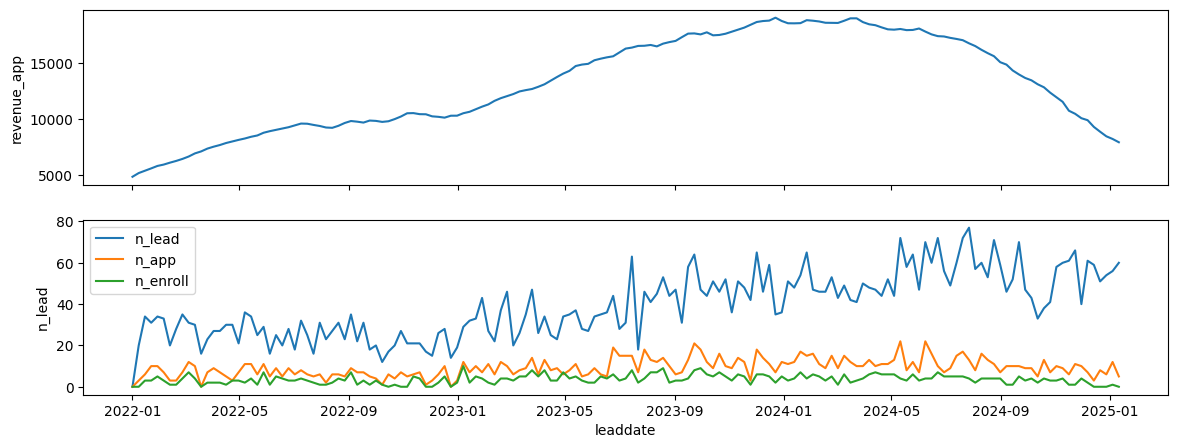

In [19]:
df_gr = df_kpi_cohort_weekly_aware.reset_index()
fig, axes = plt.subplots(2,1, figsize=(14,5), sharex=True)

sns.lineplot(data=df_gr, x='leaddate', y='revenue_app', ax=axes[0])
for col in ['n_lead', 'n_app', 'n_enroll']:
    sns.lineplot(data=df_gr, x='leaddate', y=col, ax=axes[1], label=col);

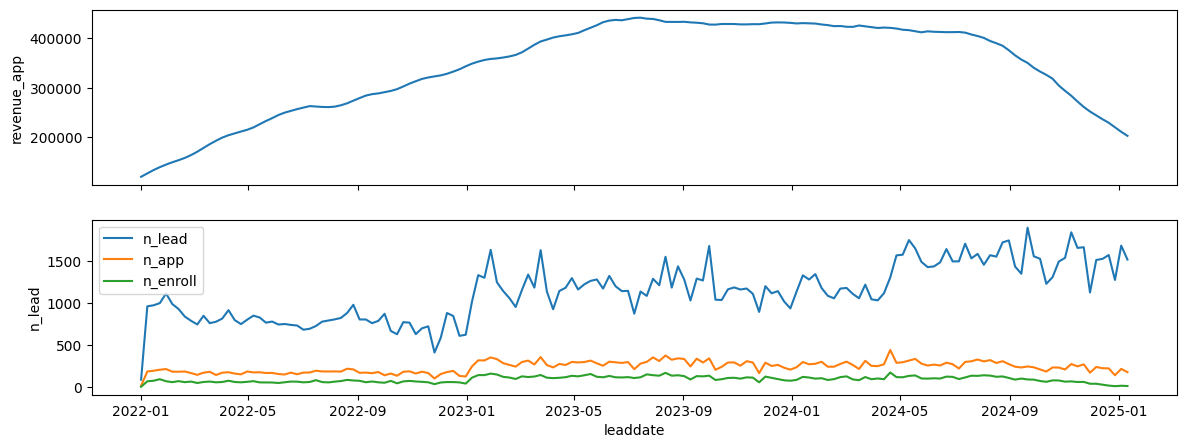

In [20]:
df_gr = df_kpi_cohort_weekly_national.reset_index()
fig, axes = plt.subplots(2,1, figsize=(14,5), sharex=True)

sns.lineplot(data=df_gr, x='leaddate', y='revenue_app', ax=axes[0])
for col in ['n_lead', 'n_app', 'n_enroll']:
    sns.lineplot(data=df_gr, x='leaddate', y=col, ax=axes[1], label=col);

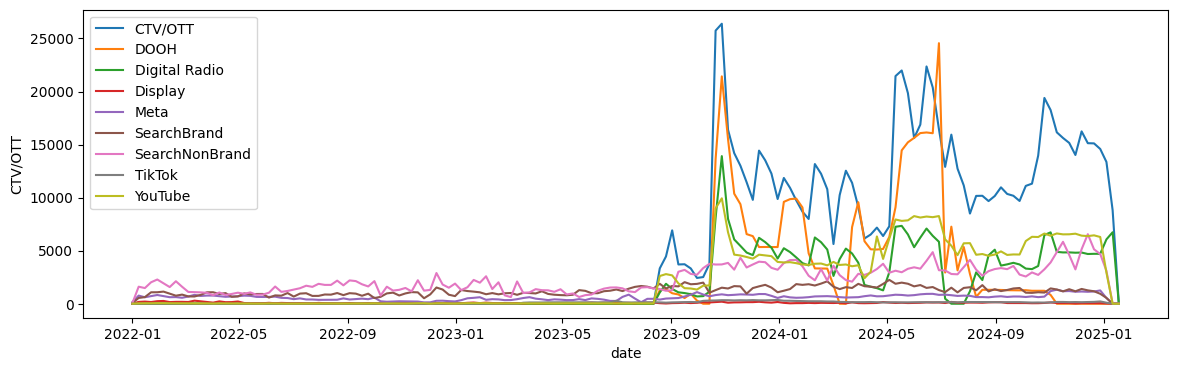

In [21]:
df_gr = df_spend_weekly_aware
plt.figure(figsize=(14,4))

for col in df_gr.columns:
    sns.lineplot(data=df_gr, x=df_gr.index, y=col, label=col);

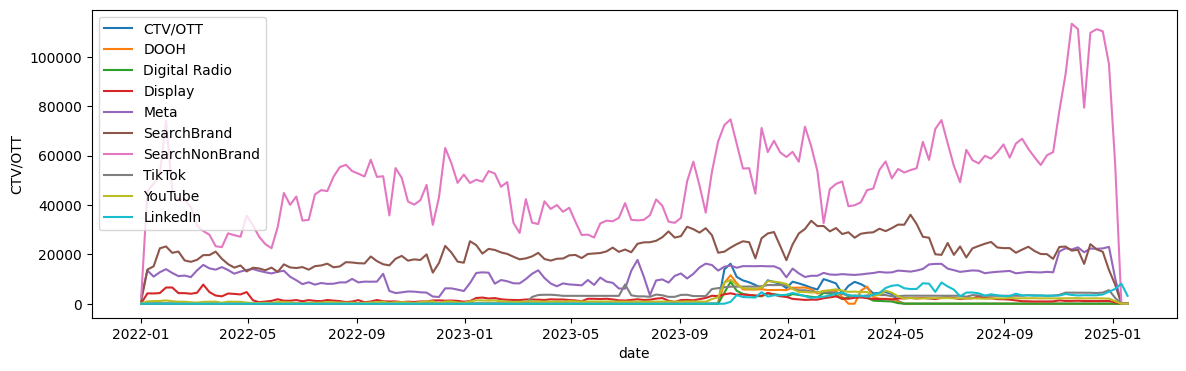

In [22]:
df_gr = df_spend_weekly_national
plt.figure(figsize=(14,4))

for col in df_gr.columns:
    sns.lineplot(data=df_gr, x=df_gr.index, y=col, label=col);